In [12]:
from modfs.data.result_load import load_results, add_derived_columns
from pathlib import Path
from typing import cast
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import pandas as pd
import modfs.utils.plotting as plot


ROOT_PATH = Path('..').resolve().parent
FIGS_DIR = ROOT_PATH / "data/figs/mascot_2023_10_10"
FIGS_DIR.mkdir(exist_ok=True, parents=True)

results_path = ROOT_PATH / "data/run"

df_original = load_results(results_path)
df_all = df_original[df_original["modular_algorithm"].isin(["constraint", "cocktail"])].copy()
names = {"cocktail": "MAS", "constraint": "CP"}

df_all = add_derived_columns(
    df_all,
    groups={
        "homogeneous": {
            f"printer_cases/duplex/{v}{a}"
            for v in ["bookletA", "bookletB", "bookletAB", "length"]
            for a in ["Uniform", ""]
        },
        "heterogeneous": {
            f"mixed/duplex/{v}{a}"
            for v in ["bookletA", "bookletB", "bookletAB", "length"]
            for a in ["Uniform", ""]
        },
        "deadlines": {"deadlines/bookletAB"},
    },
    gen_subpath="data/gen",
    exclude_paths=[],
)

df_all = df_all[(df_all["group"] != "deadlines") & (df_all["modular_algorithm"] != "Broadcast")]
df_solved = df_all[df_all["solved"]].copy()

FIGSIZE = (3, 4)


Looking for files to load


Loading info files:   0%|          | 0/48 [00:00<?, ?it/s]

All files loaded!


group
heterogeneous    1.178485
homogeneous      1.116384
Name: makespan, dtype: float64

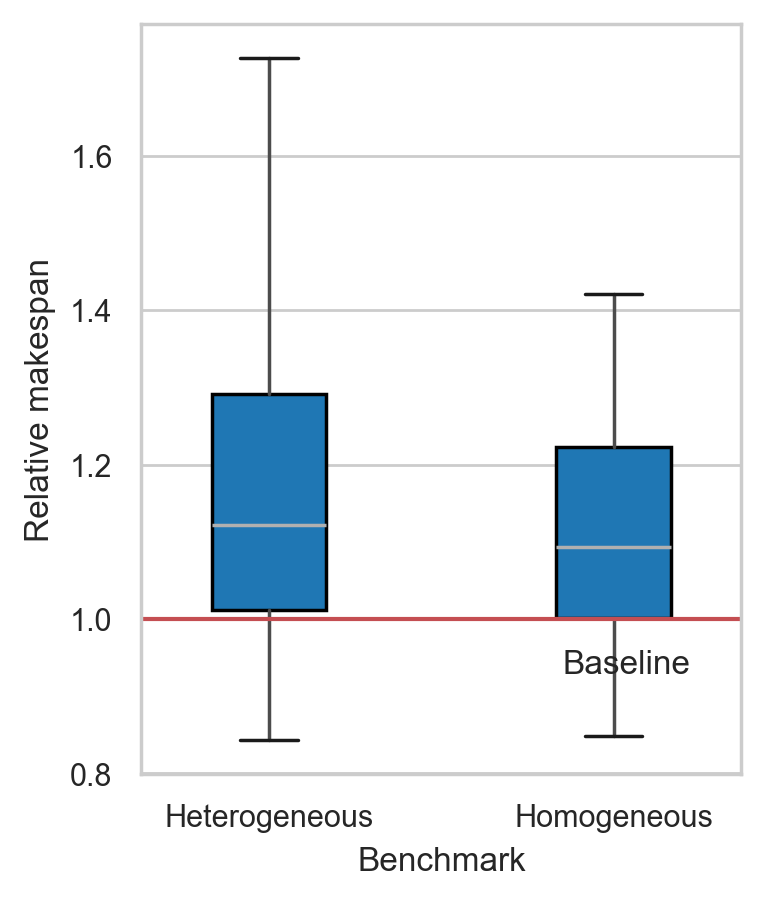

In [13]:
# Draw boxplot comparing the makespan
df_compared = plot.baseline_makespan_compare(*plot.baseline_extract(df_solved, "constraint"))
display(df_compared.groupby("group")["makespan"].mean())

colors = {
    "basic": "tab:blue",
    "constraint": "tab:green",
    "modular": "tab:olive",
}
markers = {"constraint": ".", "modular": "*"}

fig = plt.figure(figsize=FIGSIZE, dpi=250)
ax = plt.gca()
sns.set(context="paper", style="whitegrid")
df_compared.boxplot(
    by="group",
    column="makespan",
    ax=ax,
    positions=[0.15, 1.5],
    whis=(5, 95),
    widths=0.45,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor=colors["basic"]),
)
plt.axhline(y=1, color="r")
plt.text(1.3, 0.93, "Baseline")

fig.suptitle("")
plt.title("")

plt.ylabel("Relative makespan")
plt.xlabel("Benchmark")
plt.xticks([0.15, 1.5], ["Heterogeneous", "Homogeneous"])
plt.grid(axis="x")
plt.savefig(FIGS_DIR / "makespan_all.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

group          modular_algorithm
heterogeneous  cocktail             0.890509
               constraint           0.985648
homogeneous    cocktail             0.909259
               constraint           0.987963
Name: solved, dtype: float64

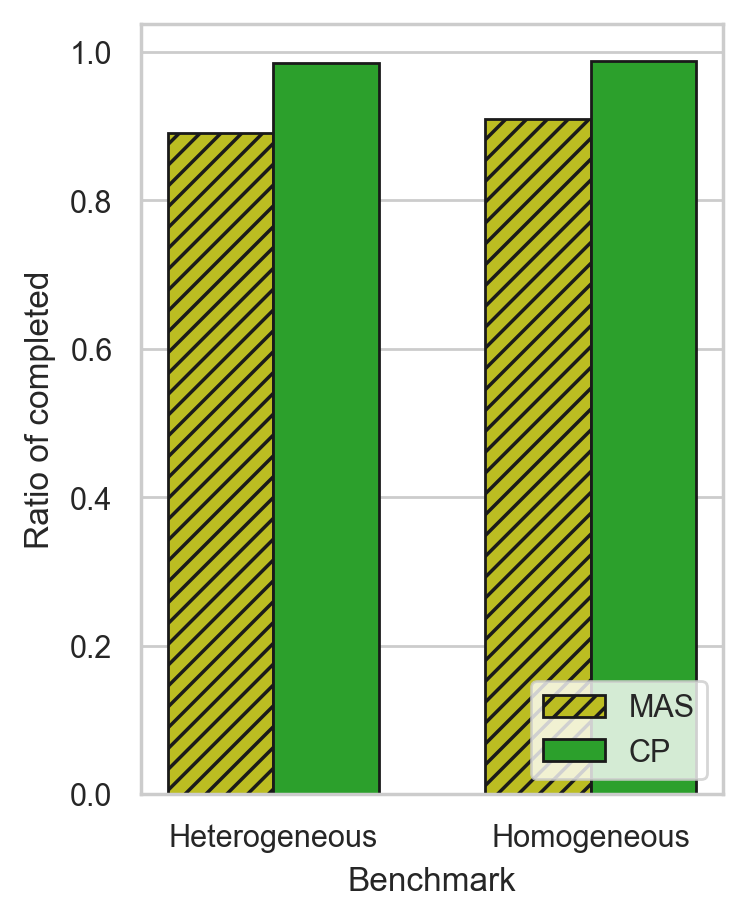

In [14]:
# Draw bar plot comparing number of finished solutions
df_completed = df_all.groupby(["group", "modular_algorithm"])["solved"].mean()
display(df_completed)

plt.figure(figsize=FIGSIZE, dpi=250)
sns.set(context="paper", style="whitegrid")
plt.bar(
    [0, 0.5, 1.5, 2],
    [
        df_completed["heterogeneous", "cocktail"],
        df_completed["heterogeneous", "constraint"],
        df_completed["homogeneous", "cocktail"],
        df_completed["homogeneous", "constraint"],
    ],
    width=0.5,
    edgecolor="k",
    color=[colors["modular"], colors["constraint"]] * 2,
    hatch=["////", ""] * 2,
)
from matplotlib.patches import Patch
plt.legend(
    handles=[
        Patch(facecolor=colors["modular"], edgecolor="k", hatch="////", label=names["cocktail"]),
        Patch(facecolor=colors["constraint"], edgecolor="k", label=names["constraint"]),
    ],
    loc="lower right",
)
plt.xticks([0.25, 1.75], ["Heterogeneous", "Homogeneous"])
plt.ylabel("Ratio of completed")
plt.xlabel("Benchmark")
plt.grid(axis="x")
plt.savefig(FIGS_DIR / "completed.pdf", bbox_inches="tight", pad_inches=0)
plt.show()


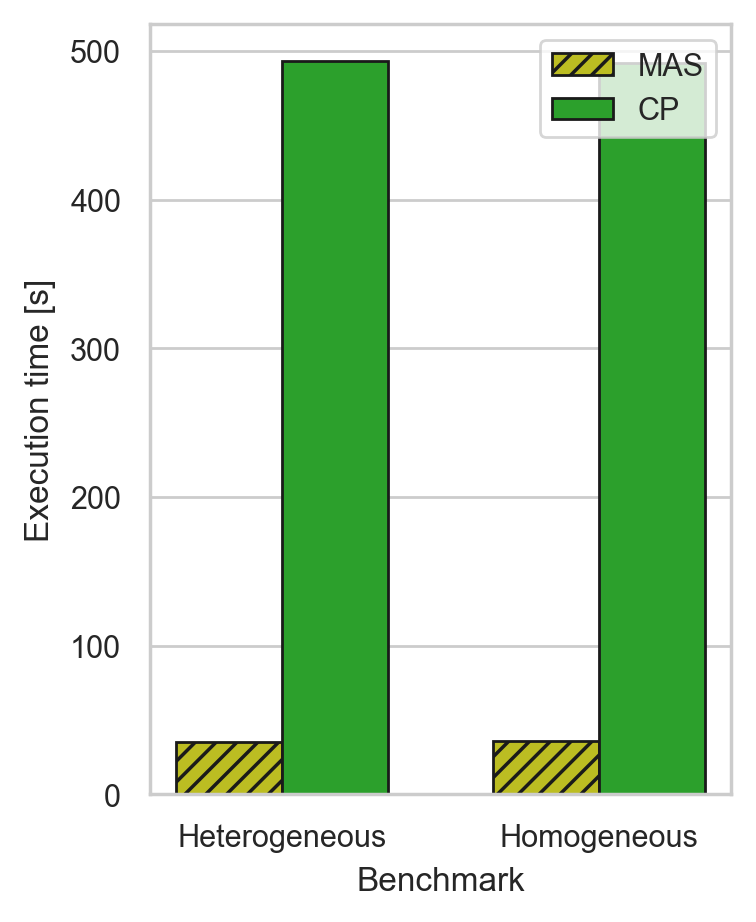

In [15]:
df_tt = df_solved.groupby(["group", "modular_algorithm"])["total_time"].mean()/1000

plt.figure(figsize=FIGSIZE, dpi=250)
sns.set(context="paper", style="whitegrid")
plt.bar(
    [0, 0.5, 1.5, 2],
    [
        df_tt["heterogeneous", "cocktail"],
        df_tt["heterogeneous", "constraint"],
        df_tt["homogeneous", "cocktail"],
        df_tt["homogeneous", "constraint"],
    ],
    width=0.5,
    edgecolor="k",
    color=[colors["modular"], colors["constraint"]] * 2,
    hatch=["////", ""]*2,
)
plt.legend(handles=[
    Patch(facecolor=colors["modular"], edgecolor="k", hatch="////", label=names["cocktail"]),
    Patch(facecolor=colors["constraint"], edgecolor="k", label=names["constraint"]),
])
plt.xticks([0.25, 1.75], ["Heterogeneous", "Homogeneous"])
plt.ylabel("Execution time [s]")
plt.xlabel("Benchmark")
plt.grid(axis="x")
plt.savefig(FIGS_DIR / "execution_time_all.pdf", bbox_inches="tight", pad_inches=0)
plt.show()
